# Receiver function inversion using optimal transport

[Sambridge, M., Jackson, A., & Valentine, A. P. (2022)](https://academic.oup.com/gji/advance-article-abstract/doi/10.1093/gji/ggac151/6572363) "Geophysical Inversion and Optimal Transport", Geophysical Journal International, ggac151, doi:10.1093/gji/ggac151.

## Utilities preparation

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install -U geo-espresso

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
import espresso

**Model vector**

We use the so-called "layer cake" parameterisation throughout the whole notebook. That means the model vector would look like:

```python
[velocity_1, thickness_1, velocity_2, thickness_2, velocity_3, ..., velocity_n]
```

In [3]:
# layercake model utilities
def form_layercake_model(thicknesses, vs):
    model = np.zeros((len(vs)*2-1,))
    model[1::2] = thicknesses
    model[::2] = vs
    return model

def split_layercake_model(model):
    thicknesses = model[1::2]
    vs = model[::2]
    return thicknesses, vs

**Interfacing to Espresso**

In [4]:
# obtain the receiver function library
rf_lib = espresso.ReceiverFunctionInversionKnt().rf

In [5]:
VP_VS = 1.77
t_shift = 5
t_duration = 25
t_sampling_interval = 0.1
gauss = 1
ray_param_s_km = 0.07

In [6]:
# forward through rf in espresso
def forward_rf(
    model, 
    t_shift=t_shift, 
    t_duration=t_duration, 
    t_sampling_interval=t_sampling_interval, 
    gauss=gauss, 
    ray_param_s_km=ray_param_s_km,
    return_times=False
):
    h, vs = split_layercake_model(model)
    data = rf_lib.rf_calc(ps=0, thik=h, beta=vs, kapa=np.ones((len(vs),))*VP_VS, p=ray_param_s_km, 
                      duration=t_duration, dt=t_sampling_interval, shft=t_shift, gauss=gauss)
    if return_times:
        times = np.arange(len(data)) * t_sampling_interval - t_shift
        return data, times
    else:
        return data

**Plotting**

In [7]:
def plot_model(model, ax=None, title="model", **kwargs):
    # process data
    thicknesses = np.append(model[1::2], max(model[1::2]))
    velocities = model[::2]
    y = np.insert(np.cumsum(thicknesses), 0, 0)
    x = np.insert(velocities, 0, velocities[0])
    
    # plot depth profile
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 0.5)),
        "alpha": 0.2,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(kwargs)
    ax.step(x, y, where="post", **plotting_style)
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()
    ax.set_xlabel("Vs (km/s)")
    ax.set_ylabel("Depth (km)")
    ax.set_title(title)
    return ax

In [8]:
def plot_data(x, y, ax=None, scatter=False, xlabel=None, ylabel=None, 
              title="surface wave data", **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 1)),
        "alpha": 1,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(**kwargs)
    if scatter:
        ax.scatter(x, y, **plotting_style)
    else:
        ax.plot(x, y, **plotting_style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

def plot_rf_data(rf_data, rf_times, ax=None, scatter=False,
                 title="receiver function data", **kwargs):
    return plot_data(x=rf_times, 
                     y=rf_data, 
                     ax=ax, 
                     scatter=scatter, 
                     title=title, 
                     xlabel="Times (s)", 
                     ylabel="Receiver function amplitudes", 
                     **kwargs)

## Synthetic example

### Generate synthetic data

In [9]:
true_thickness = np.array([10, 10, 15, 20, 20, 20])
true_vs = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315])
true_model = form_layercake_model(true_thickness, true_vs)

In [10]:
RF_STD = 0.015

rf, rf_times = forward_rf(true_model, return_times=True)
rf_dobs = rf + np.random.normal(0, RF_STD, rf.size)

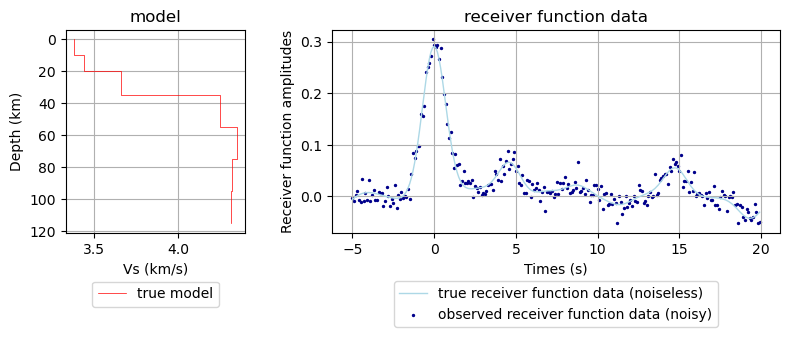

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={"width_ratios": [1,2.5]})

# plot true model
plot_model(true_model, ax=ax1, alpha=1, color="r", label="true model")
ax1.grid()

# plot receiver function data
plot_rf_data(rf, rf_times, ax=ax2, color="lightblue", label="true receiver function data (noiseless)")
plot_rf_data(rf_dobs, rf_times, ax=ax2, scatter=True, color="darkblue", s=2, 
          label="observed receiver function data (noisy)")
ax2.grid()

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
plt.tight_layout();